<p style="font-size:300%; background-color:#ffe6f0; color:#0044cc; text-align:center; line-height:80px; margin:0; padding:0;"> <b>Calibración de Cámara - Estimación de Pose</b> </p>

<p style="font-size:240%; background-color:#ffe6f0; color:#cc0000; text-align:center; line-height:60px; margin:0; padding:0;">
  <b>Inteligencia Artificial & Mini Robots</b>
</p>

<p style="font-size:200%; text-align:center; line-height:40px; margin:0;">
  <br><b>Prof. Flavio Prieto</b>
</p>

<p style="font-size:160%; text-align:center; line-height:25px; margin:0;">
  email: <a href="mailto:faprietoo@unal.edu.co">faprietoo@unal.edu.co</a>
</p>

<p style="font-size:180%; text-align:center; line-height:30px; margin:0;">
  <br><b>DEPARTAMENTO DE INGENIERÍA MECÁNICA Y MECATRÓNICA</b>
</p>

<p style="font-size:180%; text-align:center; line-height:30px; margin:0;">
  Facultad de Ingeniería
</p>

<p style="font-size:160%; text-align:center; line-height:30px; margin:0;">
  Universidad Nacional de Colombia – Sede Bogotá
</p>

<div style="text-align:center; margin-top:20px; margin-bottom:10px;">
  <img src="Fig/Escudo_UN.png" alt="Escudo UNAL" width="90" style="border:none;">
</div>

<p style="font-size:160%; text-align:center; line-height:30px; margin:0;">
  27 de noviembre de 2025
</p>

<div style="border: 2px solid #4CAF50; padding: 5px; border-radius: 4px; background-color: #e8f5e9; text-align: center;">
</div>

# CALIBRACIÓN DE CÁMARA


Presione una tecla para continuar con la siguiente imagen...
Presione una tecla para continuar con la siguiente imagen...
Presione una tecla para continuar con la siguiente imagen...
Presione una tecla para continuar con la siguiente imagen...
Presione una tecla para continuar con la siguiente imagen...
Presione una tecla para continuar con la siguiente imagen...
Presione una tecla para continuar con la siguiente imagen...
Presione una tecla para continuar con la siguiente imagen...
Presione una tecla para continuar con la siguiente imagen...
Presione una tecla para continuar con la siguiente imagen...
Presione una tecla para continuar con la siguiente imagen...
Presione una tecla para continuar con la siguiente imagen...
Presione una tecla para continuar con la siguiente imagen...
Presione una tecla para cerrar todas las ventanas...

Calibración completada correctamente.

Matriz intrínseca (K):
 [[536.07345237   0.         342.37046833]
 [  0.         536.01636205 235.5368717 ]
 [  0.

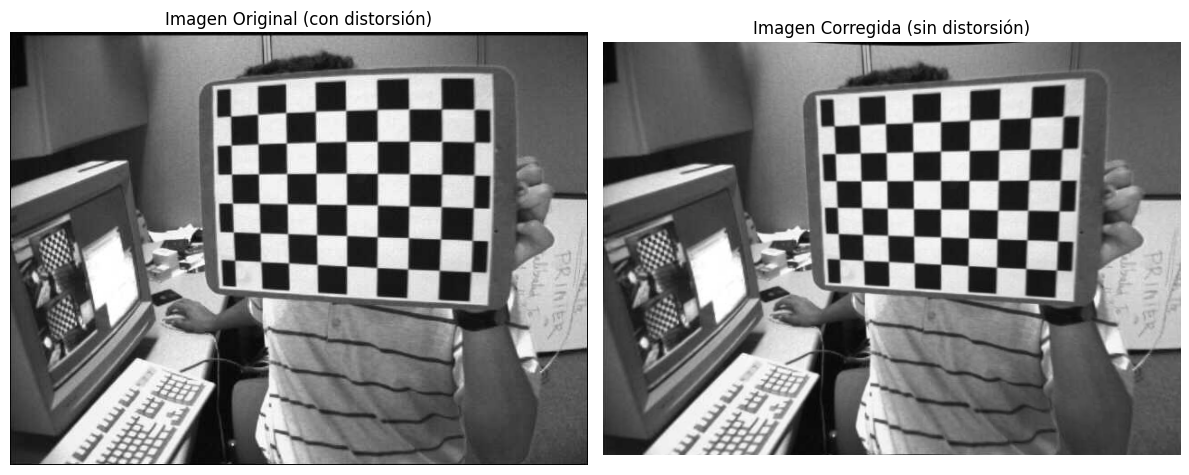

In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Definir dimensiones del patrón de calibración
# ------------------------------------------------------------
chessboard_size = (9, 6)  # Esquinas internas del tablero (filas, columnas)
square_size = 25.0        # Tamaño de cada cuadrado en mm (ajustar según el patrón físico)

# ------------------------------------------------------------
# Preparar los puntos 3D del patrón en coordenadas del mundo real
# ------------------------------------------------------------
objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
objp *= square_size

objpoints = []  # puntos 3D en el mundo real
imgpoints = []  # puntos 2D en la imagen

# ------------------------------------------------------------
# Cargar imágenes de calibración
# ------------------------------------------------------------
images = glob.glob('fig/Notebook/calib_images/*.jpg')

if len(images) == 0:
    raise FileNotFoundError("No se encontraron imágenes en la carpeta 'fig/Notebook/calib_images/'. "
                            "Asegúrese de tener fotos del tablero de ajedrez en esa carpeta.")

gray = None  # inicializar variable

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Buscar esquinas del tablero
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)

    if ret:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1),
                                    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
        imgpoints.append(corners2)

        cv2.drawChessboardCorners(img, chessboard_size, corners2, ret)
        cv2.imshow('Detección de esquinas', img)

        # Esperar hasta que el usuario presione una tecla antes de continuar
        print("Presione una tecla para continuar con la siguiente imagen...")
        cv2.waitKey(0)
    else:
        print(f"No se detectaron esquinas en: {fname}")

# Esperar antes de cerrar todas las ventanas
print("Presione una tecla para cerrar todas las ventanas...")
cv2.waitKey(0)
cv2.destroyAllWindows()

# ------------------------------------------------------------
# Calibración de cámara
# ------------------------------------------------------------
if len(objpoints) < 3:
    raise RuntimeError("No hay suficientes imágenes válidas para calibrar la cámara. "
                       "Se necesitan al menos 3 imágenes con esquinas detectadas.")

ret, K, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

print("\nCalibración completada correctamente.")
print("\nMatriz intrínseca (K):\n", K)
print("\nCoeficientes de distorsión [k1, k2, p1, p2, k3]:\n", distCoeffs.ravel())

# ------------------------------------------------------------
# Mostrar R, t y P para la primera imagen
# ------------------------------------------------------------
R, _ = cv2.Rodrigues(rvecs[0])  # Convertir vector de rotación a matriz
t = tvecs[0].reshape(3, 1)      # Asegurar forma de columna
Rt = np.hstack((R, t))          # Concatenar [R | t]
P = K @ Rt                      # Matriz de proyección

print("\nMatriz de rotación (R):\n", R)
print("\nVector de traslación (t):\n", t)
print("\nMatriz de proyección (P = K [R | t]):\n", P)

# ------------------------------------------------------------
# Corregir distorsión en una imagen de prueba
# ------------------------------------------------------------
img = cv2.imread(images[0])
h, w = img.shape[:2]

newK, roi = cv2.getOptimalNewCameraMatrix(K, distCoeffs, (w, h), 1, (w, h))
undistorted = cv2.undistort(img, K, distCoeffs, None, newK)

# Recortar la imagen corregida (ROI)
x, y, w, h = roi
undistorted = undistorted[y:y+h, x:x+w]

# ------------------------------------------------------------
# Mostrar resultados
# ------------------------------------------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Imagen Original (con distorsión)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
plt.title("Imagen Corregida (sin distorsión)")
plt.axis('off')

plt.tight_layout()
plt.show()


## Distorsión radial

### Matriz intrínseca `camera_matrix`

Representa los parámetros internos de la cámara:

\[
K =
\begin{bmatrix}
f_x & 0   & c_x \\
0   & f_y & c_y \\
0   & 0   & 1
\end{bmatrix}
\]

donde \( f_x, f_y \) son las **longitudes focales** y \( (c_x, c_y) \) es el **centro óptico**.

---

### Coeficientes de distorsión `dist_coeffs`

\[
[k_1, k_2, p_1, p_2, k_3]
\]

- \( k_1, k_2, k_3 \): **distorsión radial**  
- \( p_1, p_2 \): **distorsión tangencial**

---

### Corrección aplicada por OpenCV

El modelo de corrección de distorsión es:

\[
\begin{aligned}
x_{\text{corr}} &= x \left( 1 + k_1 r^2 + k_2 r^4 + k_3 r^6 \right)
+ 2 p_1 x y + p_2 (r^2 + 2x^2), \\[6pt]
y_{\text{corr}} &= y \left( 1 + k_1 r^2 + k_2 r^4 + k_3 r^6 \right)
+ p_1 (r^2 + 2y^2) + 2 p_2 x y,
\end{aligned}
\]

donde:

\[
r^2 = x^2 + y^2.
\]


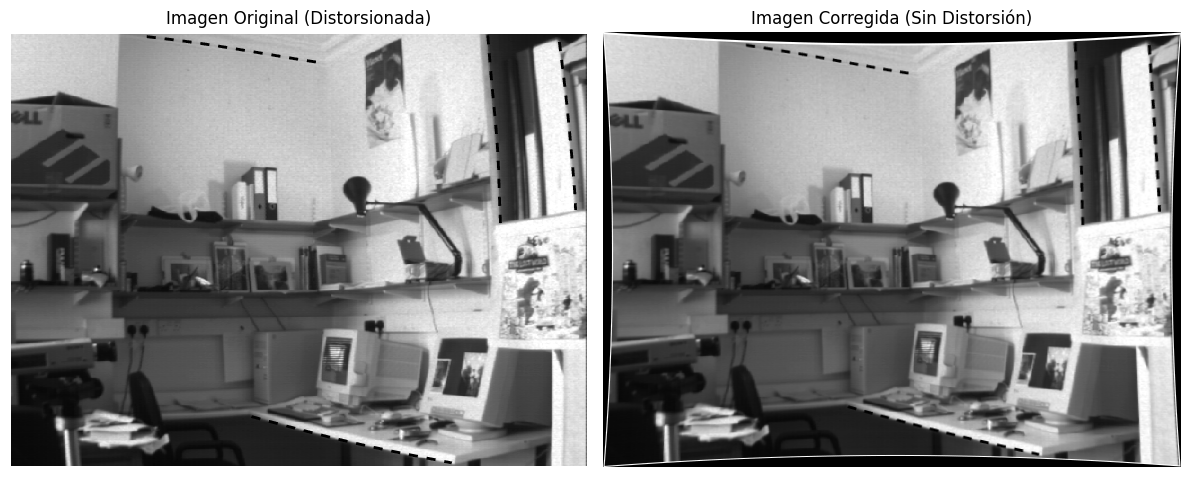

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------
# 1. Cargar imagen (distorsionada)
# --------------------------------------------------------
img_path = "fig/Latex/img26.png"  # Cambia la ruta según tu imagen
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError("No se encontró la imagen. Verifica la ruta.")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# --------------------------------------------------------
# 2. Definir parámetros intrínsecos y de distorsión
# --------------------------------------------------------
# Supón una cámara genérica (estos valores deben provenir de la calibración real)
h, w = img.shape[:2]
fx, fy = 800, 800   # Longitudes focales (en píxeles)
cx, cy = w / 2, h / 2  # Centro óptico (aprox. centro de la imagen)

camera_matrix = np.array([
    [fx, 0, cx],
    [0, fy, cy],
    [0,  0,  1]
])

# Parámetros de distorsión: [k1, k2, p1, p2, k3]
dist_coeffs = np.array([-0.35, 0.15, 0.001, 0.001, -0.05])

# --------------------------------------------------------
# 3. Calcular la corrección de la distorsión
# --------------------------------------------------------
new_camera_mtx, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w, h), 1, (w, h))
img_undistorted = cv2.undistort(img, camera_matrix, dist_coeffs, None, new_camera_mtx)

# --------------------------------------------------------
# 4. Mostrar resultados
# --------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(img)
axes[0].set_title("Imagen Original (Distorsionada)")
axes[0].axis("off")

axes[1].imshow(img_undistorted)
axes[1].set_title("Imagen Corregida (Sin Distorsión)")
axes[1].axis("off")

plt.tight_layout()
plt.show()
